## MCS tracking GPM

This notebook tracks MCS in high resolution GPM data (30 min, 0.1 x 0.1 grid) based on contiguous precipitation pixels with a precipitation intensity, area and time persistence threshold

In [387]:
import numpy as np
import os
import glob 
import random 

import matplotlib.pyplot as plt
import cartopy

import scipy
from scipy import ndimage
from scipy.ndimage import label, generate_binary_structure
import matplotlib.pyplot as plt

from netCDF4 import Dataset
from collections import Counter 

In [360]:
# read in netCDF file and save to numpy array 

working_dir= '/media/juli/Elements/GPM_IMERG_F_v05/GPM_finalrun/'
filename= '3B-HHR.MS.MRG.3IMERG.20180630-S230000-E232959.1380.V05B.HDF5.nc4'
file= working_dir + filename



# This function reads in netcdf files and returns numpy arrays with precipitation for the specific time step and respective lon and lat grids

def read_in_netcdf(file):
    date= filename[21:29]
    time= filename[31:35]
    dataset = Dataset(file)
    #print(dataset.variables.keys())
    
    time_slot= np.array(dataset["precipitationCal"])
    lon= np.array(dataset["lon"])
    lat= np.array(dataset["lat"])
    # fill lat and lon values over entire grid 
    lons= np.repeat(np.expand_dims(lon, axis= 1), np.shape(lat)[0], axis= 1 )
    lats= np.repeat(np.expand_dims(lat, axis= 0), np.shape(lon)[0], axis= 0)

    return time_slot, lons, lats
    

In [280]:
# set values below 3 km to nan, to only include the real plateau (optional)





In [361]:
# thresholds 

threshold_prec= 7 # rain rate mm/hr 
threshold_area= 10 # number of contigous pixels
threshold_timesteps= 6 #6 timesteps = 3 hr 
threshold_overlap = 1 # number of pixels for overlap 
s = generate_binary_structure(2,2) # structure element which defined what type of connections are allowed in cluster finding,here: diagonal connections 



In [380]:
## This function identifies MCS in one time slot based on a threshold rain rate and a threshold value for contiguous area
# returns following arrays for each time slot:
#  mcs : absolute rain rates 
#  mcs_labels: numbers assigned for each MCS 
# number_of_mcs: scalar containing the total number of detected mcs 

def mcs_identification(time_slot, threshold_prec, threshold_area, s ):
    
    prec_loc= np.where(time_slot > threshold_prec)
    ind_row= prec_loc[0]
    ind_col= prec_loc[1]

    im= time_slot
    im[ im < 7 ]=0
    potential_mcs, number_mcs = ndimage.label(im, structure = s) # array with nr. labels of contigous pixels above threshold and nr. of total identified MCS 

    x= potential_mcs[potential_mcs > 0 ]
    unique, counts = np.unique(x, return_counts=True)
    labels= np.asarray((unique, counts))[0]
    selection= np.asarray((unique, counts))[1] # np.array which contains all the assigned labels for areas which fulfill intensity threshold
    large = labels[selection > threshold_area]

    # create mask for pixel areas which fulfill area threshold 
    mask= np.isin(potential_mcs,large )
    # set all pixels which do not fulfill criteria to 0 in label matrix and rain rate matrix 
    potential_mcs[mask == False ]= 0
    time_slot[mask== False ]= 0 
    mcs = time_slot
    mcs_labels= potential_mcs
    # updated number of detected MCS 
    number_mcs = np.shape(np.unique(potential_mcs))[0]-1
    
    return mcs, mcs_labels, number_mcs 

In [381]:
# call function for reading in and identifying MCS in first timeslot 
time_slot, lons, lats = read_in_netcdf(file)
mcs, mcs_labels, number_mcs= mcs_identification(time_slot,threshold_prec,threshold_area, s)

In [382]:
filename_next= '3B-HHR.MS.MRG.3IMERG.20180630-S233000-E235959.1410.V05B.HDF5.nc4'
file_next= working_dir + filename_next

# read in next timestep 
time_slot_next, lons__next, lats_next = read_in_netcdf(file_next)
# identify MCS in next timestep 
mcs_next, mcs_labels_next, number_mcs_next = mcs_identification(time_slot_next,threshold_prec,threshold_area, s)

# compare timestep to next timestep and track systems with overlap (through assigning same label)



In [383]:
# comaprison between MCS identifications in both timeslots 
mcs_loc = np.nonzero(mcs_labels)
mcs_next_loc = np.nonzero(mcs_labels_next)
print('number MCS t1:  ', number_mcs, 'number MCS t2:  ', number_mcs_next)
print('number of potential MCS pixels:  ', np.shape(mcs_loc)[1], 'in next timestep: ', np.shape(mcs_next_loc)[1]  )
print('unique MCS labels t1:', np.unique(mcs_labels[mcs_labels > 0 ]), 'unique MCS labels t2:', np.unique(mcs_labels_next[mcs_labels_next > 0 ]) )

number MCS t1:   4 number MCS t2:   6
number of potential MCS pixels:   148 in next timestep:  198
unique MCS labels t1: [ 4  5 24 26] unique MCS labels t2: [ 1  4 19 25 26 29]


In [386]:
## This function compares identified MCS in the next step with MCS identified in the previous timestep
# and tracks the movement based on an overlap criterium 
# returns mcs_labels_next: updated array containing unique MCS labels (with same label for those pixel groups which have been identified belonging to the same system )



def update_labels(mcs_labels, mcs_labels_next):
    # set containing all labels with unique mcs identification numbers        
    all_mcs_labels = set(np.unique(mcs_labels[mcs_labels > 0])) #set.add 
    
    for idx, row in enumerate(mcs_labels_next):
        for col, val in enumerate(row):   
            if val > 0: # test for MCS in new time step        
                if mcs_labels[idx, col] > 0: # test if any of the pixels contains overlap 
                    mcs_labels_next[mcs_labels_next == val] = mcs_labels[idx, col] # assign old MCS label if group contains overlap 
                else:
                    new = 1 
                    new_label = range(1,1000)  # generate new identification nr if value already exists in set 
                    for i in new_label:
                        if i in all_mcs_labels:
                            new +=1           
                    if val in all_mcs_labels:
                        mcs_labels_next[mcs_labels_next == val] = new  # assign new MCS label for group without overlap 
                        
    return mcs_labels_next                

In [293]:
## This function calculates and stores the lon and lat values of the system centers defined as the mean lon/lat of all
# pixels which belong to one identified system 
# returns dictionary with the number tags for each identied MCS as key values and corresponding lat and lon values 
    
def store_coordinates(mcs_labels):
    system_stats = {} # dictionary which stores each detected MCS and corresponding center coordinates 
    for i in np.unique(mcs_labels[mcs_labels > 0]):
        system_stats.update({ str(i) : (date, time, np.mean(lats[mcs_labels == i ]) , np.mean(lons[mcs_labels == i ]), np.nanmean(mcs[ mcs_labels == i ]), np.nanmax(mcs[ mcs_labels == i ]), np.nanmin(mcs[ mcs_labels == i ])   )})          
   
    return system_stats 





In [294]:
# call function 
system_stats = store_coordinates(mcs_labels)

In [295]:
# save output MCS statistics as pandas dataframe
import pandas as pd 
stats= ['date', 'time', 'lon', 'lat', 'PREC_mean', 'PREC_max', 'PREC_min']
df= pd.DataFrame.from_dict(system_stats)
df.index = stats
df

,4,5,25,27
date,20180630,20180630,20180630,20180630
time,2330,2330,2330,2330
lon,27.1893,27.2211,36.35,39.21
lat,82.5036,83.8922,100.75,102.23
PREC_mean,16.5019,20.8652,8.96375,12.2935
PREC_max,22.1769,49.632,12.1597,13.2193
PREC_min,7.32586,7.05562,7.45359,11.4465


## Todo 


- function to extract only pixels over 3000 m 

- track MCS over time based ov overlap (rename to unique MCS labels) 

- save statistics of identified MCS and track 

- sensitivity tests for threshold 

- update plot functions

- test over multiple files 

- make the code running for GPM, MSWEP and CNRR (maybe via class identification?) 

- function to track in case MCS divides in multiple cells 

## Plots 

Number of areas with contiguous pixels > 7 mm/hr: 5


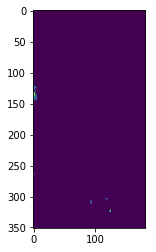

In [138]:

print('Number of areas with contiguous pixels > 7 mm/hr:', number_mcs)
plt.imshow(mcs)
plt.show()


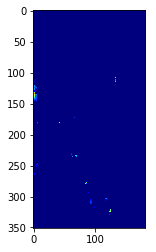

In [61]:
# plot identified MCS 

plt.imshow(time_slot, cmap=plt.cm.jet)
plt.show()
